# Modelling with new features

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [113]:
df = pd.read_csv('data_with_new_features.csv', sep=';')
df = df.drop('street', axis=1)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number of rooms       925 non-null    int64  
 1   area of apartment     925 non-null    float64
 2   number of floors      925 non-null    int64  
 3   apartment floor       925 non-null    int64  
 4   price                 925 non-null    float64
 5   repair                925 non-null    object 
 6   bathroom              925 non-null    object 
 7   terrace               925 non-null    object 
 8   year of construction  925 non-null    int64  
 9   elevator              925 non-null    int64  
 10  garbage chute         925 non-null    int64  
 11  type of house         925 non-null    object 
 12  district              925 non-null    object 
 13  concierge             925 non-null    int64  
 14  distance              925 non-null    float64
 15  price for metre       9

## Подготовка категориальных признаков

### Разбиение на данные и целевую метку

In [115]:
not_categorial_features = []
for column in df.columns:
    if df[column].dtype != 'object':
        not_categorial_features.append(column)

In [116]:
data = df[not_categorial_features].copy().drop('price', axis=1)
target = df[['price']].copy()

### One-Hot-кодирование для категориальных признаков

In [117]:
from sklearn.preprocessing import OneHotEncoder

def get_one_hot_df(df, column):
    encoder = OneHotEncoder()
    new_df = pd.DataFrame(encoder.fit_transform(df[[column]]).toarray())
    new_df.columns = [column + '_' + feature[3:] for feature in encoder.get_feature_names()]
    return new_df

In [118]:
for column in df.columns:
    if df[column].dtype == 'object':
        one_hot_df = get_one_hot_df(df, column)
        data = pd.merge(data, one_hot_df, left_index=True, right_index=True)

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   number of rooms                 925 non-null    int64  
 1   area of apartment               925 non-null    float64
 2   number of floors                925 non-null    int64  
 3   apartment floor                 925 non-null    int64  
 4   year of construction            925 non-null    int64  
 5   elevator                        925 non-null    int64  
 6   garbage chute                   925 non-null    int64  
 7   concierge                       925 non-null    int64  
 8   distance                        925 non-null    float64
 9   price for metre                 925 non-null    float64
 10  district population             925 non-null    int64  
 11  green rate                      925 non-null    int64  
 12  repair rate                     925 

## Деление на тестовую и тренировочную выборки

In [120]:
X = data.values
y = target.values

In [121]:
X.shape, y.shape

((925, 37), (925, 1))

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    random_state=42)

## XGBoost

In [123]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [124]:
xgb_reg = xgb.XGBRegressor(n_estimators=700, learning_rate=0.05,
                          max_depth=4, random_state=42) 
xgb_reg.fit(X_train, y_train.ravel()) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [125]:
predicts = xgb_reg.predict(X_test)

mse = mean_squared_error(predicts, y_test)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  350855.468


## Визуализация XGBoost

In [126]:
pd.DataFrame({'feature': data.columns, 'importance': xgb_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,area of apartment,0.322236
4,year of construction,0.109998
9,price for metre,0.085221
8,distance,0.055075
14,terrace rate,0.050547
7,concierge,0.047690
12,repair rate,0.045925
2,number of floors,0.041683
28,type of house_монолитный,0.021551
27,type of house_кирпичный,0.020669


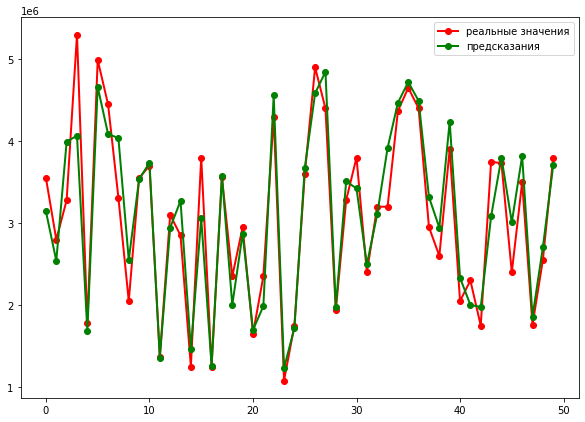

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(y_test[:50], '-ro', linewidth=2, label='реальные значения')
plt.plot(predicts[:50], '-go', linewidth=2, label='предсказания')
plt.legend()

Text(0, 0.5, 'Предсказанная цена')

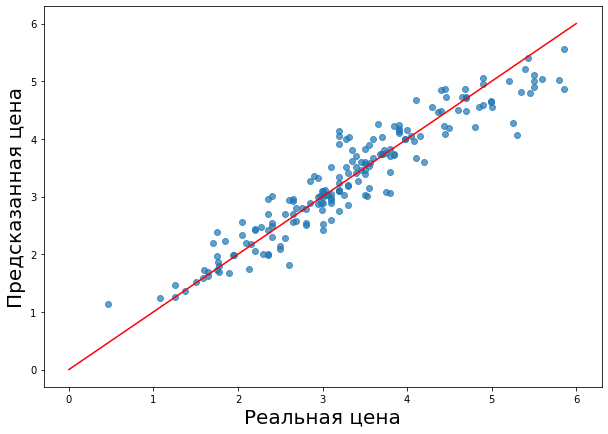

In [128]:
plt.figure(figsize=(10, 7))
plt.plot(np.array(range(7)), np.array(range(7)), c='r')
plt.scatter(y_test/1_000_000, predicts/1_000_000, alpha=0.7)
plt.xlabel("Реальная цена", size=20)
plt.ylabel("Предсказанная цена", size=20)

# Итого

Получен baseline, не хуже которого нужно будет обучить нейронную сеть. Новые введенные фичи показали, что они имеют влияние на модель xgboost. Хорошее влияние оказали цена за квадратный метр по району, оценка балкона и оценка ремонта